### COVID-19 Data Science Challenge Fall 2020: Protect Purdue
#### _Predicting social crowding in Tippecanoe county._


## Section 1
---

In this project, the aim is to make a prediction of foot traffic for week 44 (since Indiana recorded first COVID-19 case) in 1804 Point of Interests (POIs) in Tippecanoe County in Indiana, United States of America (a regression task). The data that is being used has been collected from the week 1 to week 43 and is available as a BIgQuery project file. The schema of the tables that will be used for this project can be found [here](https://docs.google.com/spreadsheets/d/e/2PACX-1vQUgT-CyXoPO6Fa4r4YlwF6uqHMvcqiWM4UNlUqYNdrljntzZsL8sU9-BIZZIOdd_CO3W5ILB_MW4TW/pubhtml).

To start with, the six tables would be imported from the BigQuery project and stored as a pandas DataFrame. Then, Exploratory Data Analysis (EDA) would be carried out on the data to better understand their relationships for feature selection for the modeling task. For this challenge, some of the various models I used were:
* Arima
* Random Forest
* LightGBM
* Catboost

The result presented in this report was obtained using catboost. This report visualized the effectiveness of the policies taken during the fall in five poi locations that reported the highest cases of the virus.

## Section 2
#### _Terms and Abbreviations_
---

Data:
 * main_data: The primary data used for analysis
 * prediction: File of predicted cases for week 44
 * df_merge_col: Merged data for spatial representation
 


In [4]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
from ipywidgets import *
from ipyleaflet import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor 
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from google.cloud import bigquery
from google.oauth2 import service_account
from google.cloud.bigquery import magics
import os
from ipywidgets.embed import embed_minimal_html
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [144]:
main_data = pd.read_csv('main_file_copy.csv')
prediction = pd.read_csv('submission_prediction_output8_copy.csv')
df_merge_col = pd.read_csv('ff.csv')
df_new = pd.read_csv('cbg_file.csv')

In [7]:
top_20 = list(prediction.head(20)['poi_id']);

### Merging the main_data with the predictions

In [11]:
def new_data(i):
    poi_data = main_data[main_data['poi_id']==i][['raw_visit_counts', 'date_start']]
    new_poi_data = prediction[prediction['poi_id']==i][['raw_visit_counts', 'date_start']]
    return pd.concat([poi_data, new_poi_data], ignore_index=True).set_index('date_start')

In [100]:
def plot_gra(df):
    ax.plot(df, marker='o', linestyle='-', label=list(main_data[main_data['poi_id']==j]['location_name'])[0])
    ax.set_ylabel('Weekly COVID-19 Cases')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xticks(rotation=45)

## Section 3.1
---

#### For the Twenty most Crowded Places

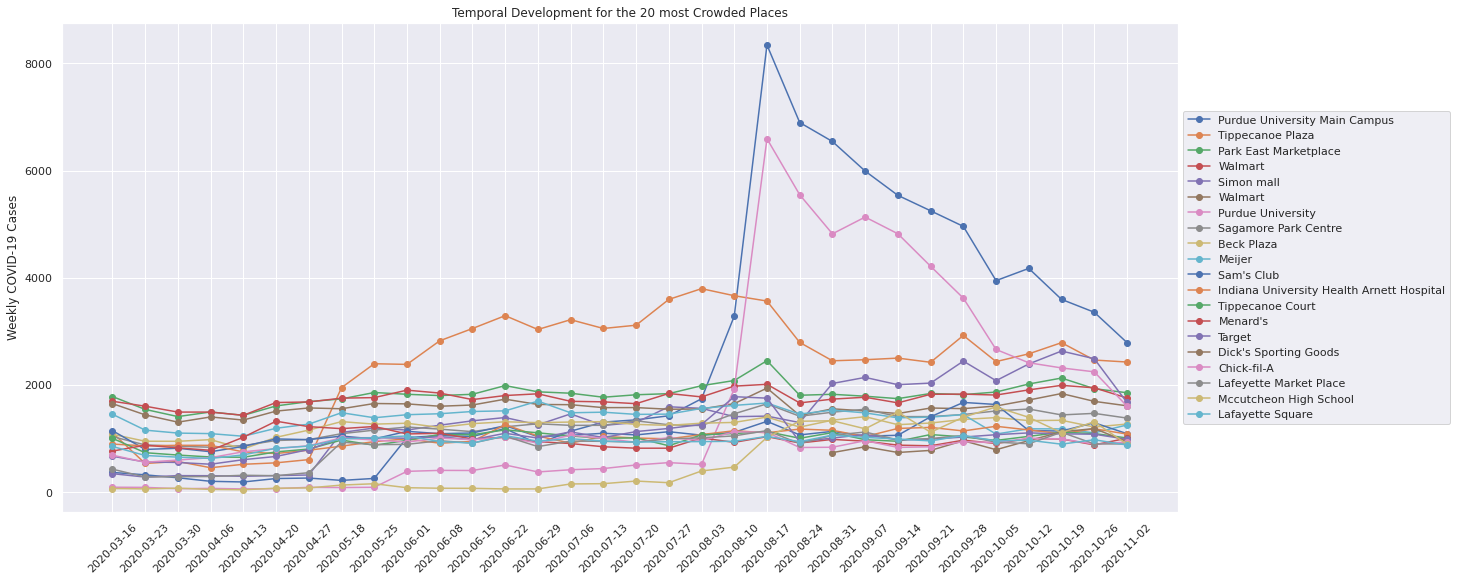

In [102]:
fig, ax = plt.subplots(figsize=(20,9))
ax.set_title('Temporal Development for the 20 most Crowded Places')
for j in top_20:
    plot_gra(new_data(j))
plt.savefig('temporal_20.png')

#### For the Twenty most Increased Places

In [64]:
file_main = main_data[main_data['week_number']==40][['poi_id', 'raw_visit_counts']]
file_main.reset_index(inplace = True)
file_main.drop(columns = 'index', inplace=True)

In [66]:
file_main.columns = ['poi_id', 'raws_visit_counts_40']
merged_file = pd.merge(file_main, prediction, on='poi_id')
merged_file['increase'] = merged_file['raw_visit_counts'] - merged_file['raws_visit_counts_40']
merged_file.sort_values('increase', ascending=False, inplace=True)

In [68]:
top_20_increase = list(merged_file['poi_id'].head(20)); 

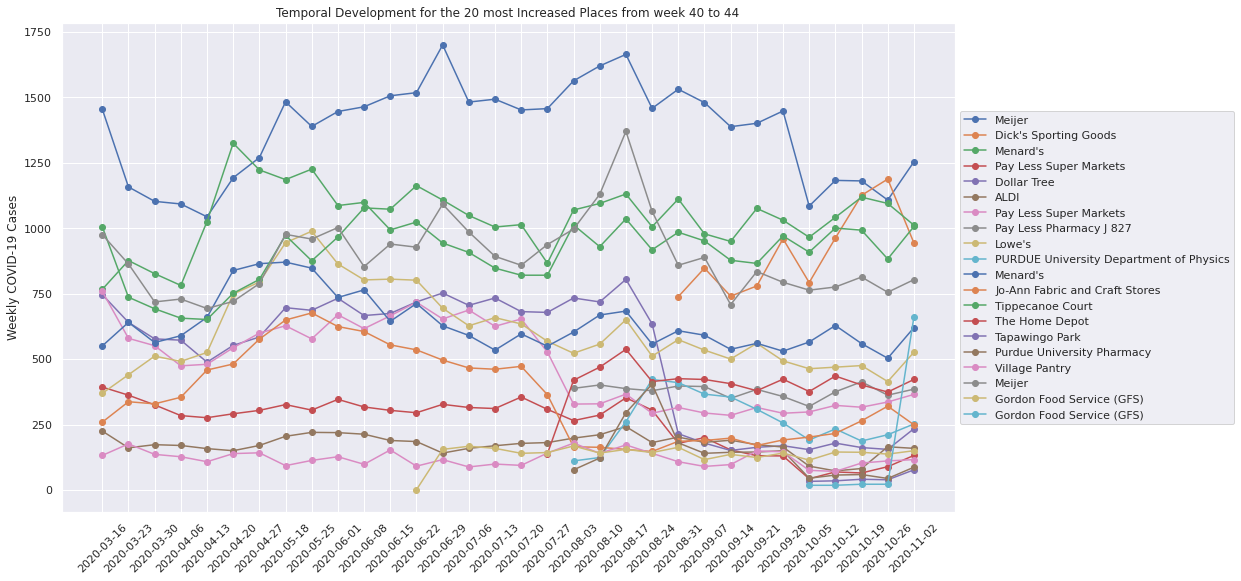

In [101]:
fig, ax = plt.subplots(figsize=(20,9))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('Temporal Development for the 20 most Increased Places from week 40 to 44')
for j in top_20_increase[1:]:
    plot_gra(new_data(j))
plot_gra(new_data(top_20_increase[0]))    
plt.savefig('temporal_increased.png')

### Temporal Mapping

The predictions for week 44 is visualized below on an interactive map showing places around Tipcanoe county and the predicted values

In [105]:
# CONSTANTS
MAP_LAT=40.3900
MAP_LON=-86.8220
MAP_CENTER = (MAP_LAT, MAP_LON)

#### Absolute Values for Week 44

In [106]:
m = Map(center=MAP_CENTER, zoom=10)

markers = []

for index, point in df_merge_col.iterrows():
    marker = Marker(
        location=[point.latitude, point.longitude],
        draggable=False,
    )
    marker_message = HTML()
    marker_message.value = "<strong>" + str(point.location_name) + "</strong>" + "<br>Visit Count: " + str(point.raw_visit_counts)
    marker.popup = marker_message
    markers.append(marker)

m.add_layer(MarkerCluster(markers=markers))

display(m)

Map(center=[40.39, -86.822], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

In [125]:
embed_minimal_html('map1.html', views=[m])

#### Temporal Development for Greatest Increase

In [114]:
file_main_1 = main_data[main_data['week_number']==40][['poi_id', 'raw_visit_counts', 'longitude', 'latitude', 'location_name']]
file_main_1.reset_index(inplace = True)
file_main_1.drop(columns = 'index', inplace=True)

file_main_1.columns = ['poi_id', 'raws_visit_counts_40', 'longitude', 'latitude', 'location_name']
merged_file_1 = pd.merge(file_main_1, prediction, on='poi_id')
merged_file_1['increase'] = merged_file_1['raw_visit_counts'] - merged_file['raws_visit_counts_40']
merged_file_1.sort_values('increase', ascending=False, inplace=True)
merged_file_1.reset_index(inplace=True)

In [116]:
m = Map(center=MAP_CENTER, zoom=10)

markers = []

for index, point in merged_file_1.iterrows():
    marker = Marker(
        location=[point.latitude, point.longitude],
        draggable=False,
    )
    marker_message = HTML()
    marker_message.value = "<strong>" + str(point.location_name) + "</strong>" + "<br>Visit Count: " + str(point.increase)
    marker.popup = marker_message
    markers.append(marker)

m.add_layer(MarkerCluster(markers=markers))

display(m)

Map(center=[40.39, -86.822], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

In [117]:
embed_minimal_html('map2.html', views=[m])

## Section 3.2
---

In [154]:
df_new.groupby(['poi_cbg'])['raw_visit_counts'].sum()

poi_cbg
181570001001     177
181570001002     899
181570002001     228
181570002002     136
181570003001    1312
                ... 
181570110002     113
181570110003     229
181570111001     155
181570111002    2959
181570111003     182
Name: raw_visit_counts, Length: 100, dtype: int64

### Conclusing Remarks

To say I am excited I completed this hackathon would be largely an understatement. In fact, I did not submit the first three submissions because I could not set up the model using my favorite xgboost. However, the constant reminder via email and the support of being placed in a group reinvigorated my spirit and I am really glab I explored four different models for the hackathon. I think I can now change my LinkedIn header from "data analyst" to "data scientist" after months of inferirority complex. Simply put, what I learnt from this hackathon is how much tenacity is needed in the data science space. Thank you for the opportunity to learn while helping to combat the virus! I look forward to more of it.

Lawal Ogunfowora.